<a href="https://colab.research.google.com/github/sam-vermeulen/connectfourproject/blob/main/connect_four_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Libraries

In [6]:
import jax, jax.numpy as jnp
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import functools
from urllib.request import urlopen

# we use 64 bit bitboards to represent our game.
jax.config.update('jax_enable_x64', True)

jnp.set_printoptions(precision=100, linewidth=100000)

# check GPU support
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

!pip install git+https://github.com/deepmind/dm-haiku

import haiku as hk

zsh:1: command not found: nvidia-smi
  Cloning https://github.com/deepmind/dm-haiku to /private/var/folders/yw/ckylxvy95xld6whm7608ymr80000gn/T/pip-req-build-47za6zxq
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /private/var/folders/yw/ckylxvy95xld6whm7608ymr80000gn/T/pip-req-build-47za6zxq
  Resolved https://github.com/deepmind/dm-haiku to commit 2746c39a8e335046598d9eaa81cc990cae224691
  Preparing metadata (setup.py) ... done


# Configuration

In [7]:
default_config={'width': 7, 'height': 6, 'temperature': 0.0000001}

# Environment Code

This contains all the connect four environment code. The code for this environment is an adaptation of the implementations by:
* Pascal Pon (http://blog.gamesolver.org/)
* John Tromp (https://tromp.github.io/c4/c4.html)

These sites give an in-depth explaination about the environment. 

My implementation allows the games to be vectorized, and has functions that make batching and rollouts easy to implement.

In [8]:
def get_piece_locations(config=default_config):
  # Returns an array containing the bit locations of each piece on the bitboard
  return jnp.array([2 ** (col + config['width'] * row) for row in range(config['height']) for col in range(config['width'])], dtype=jnp.uint64)

@jax.jit
def state_to_array(state, piece_locations, config=default_config):
  '''Represents the game state in an (..., 84), array'''
  # The first 42 elements are the current players piece locations
  # The last 42 elements are the opponent players piece locations

  # converts the player state to an array containing the current players pieces
  current_player = jnp.bitwise_not(is_empty_intersection(state[0], piece_locations))

  # converts the opponent state to an array containing the opponent players pieces
  opponent = jnp.bitwise_not(is_empty_intersection(get_opponent_state(state)[0], piece_locations))

  return jnp.concatenate([current_player, opponent], axis=-1).astype(float)

@jax.jit
def is_empty_intersection(bb_a, bb_b):
  # Check if two bitboards have not active bits in common
  return jnp.bitwise_and(bb_a, bb_b) == 0

def init_game(games_shape=1, config=default_config):
  '''initializes the game state tuple to the start of the game'''
  # Rmk: games_shape can be a number with the amount of games you want
  #       OR you can specify a shape tuple. eg. 10000, (1000, 10), and (10, 10, 10, 10) are all valid

  position = jnp.expand_dims(jnp.zeros(games_shape, dtype = jnp.uint64), axis=-1)
  mask = jnp.expand_dims(jnp.zeros(games_shape, dtype = jnp.uint64), axis=-1)
  active = jnp.expand_dims(jnp.ones(games_shape, dtype = jnp.uint64), axis=-1)
  count = 0

  return (position, mask, active, count)

@jax.jit
def get_column_list(config=default_config):
  # returns a list of column numbers. For 6x7 game: [0, 1, 2, 3, 4, 5, 6]
  return jnp.arange(default_config['width'], dtype=jnp.uint64)

@jax.jit
def get_board_mask(config=default_config):
  '''get a bitmask with all bits on'''
  return (1 << (config['height'] + 1) * config['width']) - 1

@jax.jit
def top_mask(col, config=default_config):
  '''get a bitmask with a 1 at the top of given column'''
  return (1 << (config['height'] - 1)) << (col * (config['height'] + 1))

@jax.jit
def bottom_mask(col, config=default_config):
  '''get a bitmask with a 1 at the bottom of the given column'''
  return 1 << col * (config['height'] + 1)

@jax.jit
def bottom_row_mask(config=default_config):
  '''get a bitmask with all the bits at the bottom of the board on'''
  h1 = config['height'] + 1
  size1 = h1 * config['width']
  all1 = (1 << size1) - 1
  col1 = (1 << h1) - 1
  return jnp.array(all1 / col1, dtype=jnp.uint64)

@jax.jit
def column_mask(col, config=default_config):
  '''get a bitmask with the bits of the given column on'''
  return ((1 << config['height']) - 1) << (col * (config['height'] + 1))

@jax.jit
def can_play(state, col, config=default_config):
  '''check if we can play in the given column'''
  _, mask, _, _ = state
  #print("maskcanplay", mask.shape)
  #print("topmask", top_mask(col, config).shape)
  #print("masktop", ((mask & top_mask(col, config)) == 0).shape)
  return (mask & top_mask(col, config)) == 0

@jax.jit
def alignment(state, config=default_config):
  '''checks if there is an alignment for the current player'''
  position, mask, active, count = state

  m = position & (position >> (config['height'] + 1))
  horizontal = jnp.where(m & (m >> (2 * (config['height'] + 1))), 1, 0)

  m = position & (position >> config['height'])
  diag_a = jnp.where(m & (m >> (2 * config['height'])), 1, 0)

  m = position & (position >> (config['height'] + 2))
  diag_b = jnp.where(m & (m >> (2 * (config['height'] + 2))), 1, 0)

  m = position & position >> 1
  vertical = jnp.where(m & (m >> 2), 1, 0)
  
  alignment = horizontal | diag_a | diag_b | vertical
  
  return alignment

@jax.jit
def get_legal_cols(state, config=default_config):
  # returns a boolean list of legal columns
  # ie. if a column is full, the entry for the corresponding column will be False
  legal_cols = can_play(state, get_column_list(), config)
  return legal_cols

@jax.jit
def get_opponent_state(state):
  '''gets the bitboard from the opponents perspective'''
  # the opponent position is the bitwise XOR between position and mask.

  position, mask, active, count = state

  opponent_state = (position ^ mask, mask, active, count)
  return opponent_state

@jax.jit
def update_active_games(state, config=default_config):
  '''checks if the given game is still active and updates the active array'''
  position, mask, active, count = state

  opponent_state = get_opponent_state(state)
  active = 1 - (alignment(opponent_state, config) | alignment(state, config) | (count >= 41))

  return (position, mask, active, count)

@jax.jit
def any_active_games(state, config=default_config):
  position, mask, active, count = state
  return jnp.any(active)

@jax.jit
def play_move(state, col, config=default_config):
  '''plays a move in the given column'''
  # note: this switches the players perspective then adds the bitmask
  #       with only an active bit at the bottom of the chosen column to
  #       the 'mask' bitmask this shifts all the bits in that column left by 1.

  # col must be of shape (pre-shape, 1) or a single integer
  position, mask, active, count = state

  position = position ^ mask

  legal = can_play(state, col, config) & active

  new_mask = mask | (mask + bottom_mask(col.astype(jnp.uint64), config))

  mask = jnp.where(legal, new_mask, mask)

  state = (position, mask, active, count)
  _, _, active, _ = update_active_games(state, config)

  count = count + 1

  return (position, mask, active, count)

@jax.jit
def get_winners(state, config=default_config):
  '''gets the winners of the current board'''
  # -1 if red wins
  #  1 if black wins
  # if there are two winners we get 0 (covers invalid game)
  # if there are no winners we get 0 (covers tie/game not over)
  position, mask, active, count = state
  opponent_state = get_opponent_state(state)

  current_alignments = alignment(state)
  opponent_alignments = alignment(opponent_state) * (-1)

  whos_turn = count & 1
  win_value = 2 * whos_turn.astype(jnp.int32) - 1 # -1 if red win, 1 is black win

  # score will be -1 if red has alignment, 1 if black has alignment, 0 if tied, 0 if both have alignments (invalid game)
  total_score = current_alignments * win_value + opponent_alignments * win_value

  return total_score

@jax.jit
def get_game_shape(state):
  return state[0].shape[:-1]

def get_all_shapes(state):
  return (state[0].shape, state[1].shape, state[2].shape, (1))

@jax.jit
def get_player_turn(state):
  '''gets whos turn it currently is'''
  return state[3]&1

@jax.jit
def get_winning_columns(state, config=default_config):
  '''gets the first columns that would make the current player win immediately'''
  # -1 if there are no winning columns

  col_masks = column_mask(get_column_list())
  win_mask = get_winning_bitmask(state)
  winning_cols = jnp.where(col_masks & win_mask != 0, 1, 0)

  return winning_cols

@jax.jit
def get_threatening_columns(state, config=default_config):
  '''gets the first column that would make the current player win immediately'''
  opponent_state = get_opponent_state(state)
  return get_winning_columns(opponent_state)

@jax.jit
def get_winning_bitmask(state, config=default_config):
  '''gets a bitmask with 1s in positions that would immediately end the game'''
  pos, mask, _, _ = state

  h = config['height']

  # vertical
  r = (pos << 1) & (pos << 2) & (pos << 3)

  # horizontal
  p = (pos << (h + 1)) & (pos << 2 * (h+1))
  r = r | (p & (pos << 3 * (h + 1)))
  r = r | (p & (pos >> (h + 1)))
  p = p >> (3 * (h + 1))
  r = r | (p & (pos << (h + 1)))
  r = r | (p & (pos >> (3 * (h + 1))))

  # diag 1
  p = (pos << h) & (pos << 2 * h)
  r = r | (p & (pos << 3 * h))
  r = r | (p & (pos >> h))
  p = p >> (3 * h)
  r = r | (p & (pos << h))
  r = r | (p & (pos >> 3 * h))

  # diag 2
  p = (pos << (h + 2)) & (pos << 2 * (h + 2))
  r = r | (p & (pos << 3 * (h + 2)))
  r = r | (p & (pos >> (h + 2)))
  p = p >> (3 * (h + 2))
  r = r | (p & (pos << (h + 2)))
  r = r | (p & (pos >> 3 * (h + 2)))

  return r & (get_board_mask(config) ^ mask)

def expand_to_next_states(state, config=default_config):
  '''expands the bitboard to all possible next states'''

  position, mask, active, count = state

  p_position = jnp.repeat(jnp.expand_dims(position, -2), 7, axis = -2)
  p_mask = jnp.repeat(jnp.expand_dims(mask, -2), 7, axis = -2)
  p_active = jnp.repeat(jnp.expand_dims(active, -2), 7, axis = -2)

  p_state = (p_position, p_mask, p_active, count)

  action = jnp.linspace(0, config['width'] - 1, config['width'], dtype=jnp.uint64)
  p_state = play_move(p_state, action[:, None], config)

  return p_state

@functools.partial(jax.jit, static_argnums=1)
def repeat_game(state, repeats, config=default_config):
  '''adds axis and repeats the game_state along the axis repeat times'''
  # output shape: (repeats, pre-shape, 1)
  position, mask, active, count = state

  p_position = jnp.repeat(jnp.expand_dims(position, 0), repeats, axis=0)
  p_mask = jnp.repeat(jnp.expand_dims(mask, 0), repeats, axis=0)
  p_active = jnp.repeat(jnp.expand_dims(active, 0), repeats, axis=0)

  p_state = (p_position, p_mask, p_active, count)

  return p_state

def to_array(game_state, game_num, config=default_config):
    position, mask, active, count = game_state

    board_size = (config['height']+1) * config['width']
    pieces = jnp.reshape(2 << (jnp.array(jnp.linspace(0, board_size - 1, board_size), dtype=jnp.uint64) - 1), (config['height'] + 1, config['width'])).T
    pieces = pieces.at[0, 0].set(1)
    pieces = jnp.flip(pieces, 0)

    current_player = jnp.where(pieces & position[game_num] != 0, 1 + (count&1), 0)
    other_player = jnp.where(pieces & (position ^ mask)[game_num] != 0, 2 - (count&1), 0)

    return current_player + other_player

def draw_game(game_state, game_num = 0, player_color = ['red','black'], config=default_config):
  '''Use matplotlib to draw the board in text given the bitboards for player 1 and player 2'''

  position, mask, active, count = game_state

  fig, ax = plt.subplots()
  plt.xlim(-0.5, config['width'] - 0.5)
  plt.ylim(config['height']+0.5, 0.5)
  ax.patch.set_facecolor('lightgrey')

  game_array = to_array(game_state, game_num)

  for y in range(1, config['height']+1):
    for x in range(config['width']):
      outline = plt.Circle((x,y), 0.45, color='white')
      ax.add_patch(outline)

      if game_array[y, x] > 0:
        piece = plt.Circle((x, y), 0.45, color=player_color[game_array[y, x] - 1])
        ax.add_patch(piece)

  plt.show()

In [9]:
print(get_column_list())

jnp.arange(default_config['width'], dtype=jnp.uint64)

[0 1 2 3 4 5 6]


Array([0, 1, 2, 3, 4, 5, 6], dtype=uint64)

# Agents

## Helper Agents

Contains:
* Base Agent - for subtyping
* Player Agent - lets real people play the game

In [10]:
# Base agent class

class Agent():
  def __init__(self, config=default_config):
    self.config = config

  def choose(self, state, key=None, verbose=False):
    pass

# Player agent let's real people play the game

class PlayerAgent(Agent):
  def __init__(self, config=default_config):
    super().__init__(config=config)

  def choose(self, state, key=None, verbose=False):
    '''chooses actions using the state'''
    # in: state - a 4-tuple with the current game state (position, mask, active, turn)
    #     key - the jax random key
    # out: an action to take for each game

    draw_game(state)
    print('Which column would you like to play in')
    raw_input = input()

    choice = jnp.clip(int(raw_input), 0, self.config['width'])

    return choice[..., jnp.newaxis]

## Random Agent

This agent chooses actions according to a uniform random policy.

In [11]:
class RandomAgent(Agent):
  def __init__(self, config=default_config):
    super().__init__(config=config)

  def choose(self, state, key=None, verbose=False):
    '''chooses actions using the state'''
    # in: state - a 4-tuple with the current game state (position, mask, active, turn)
    #     key - the jax random key
    # out: an action to take for each game

    if key == None:
      key = jax.random.PRNGKey(int(time.time()))

    scores = jax.random.uniform(key, shape=(*state[0].shape[:-1], self.config['width']))

    # we cannot play in illegal columns, so set these to NAN
    legal_cols = get_legal_cols(state)
    legal_scores = jnp.where(legal_cols, scores, jnp.nan)

    return jnp.nanargmax(legal_scores, axis=-1)[..., jnp.newaxis]

## Random Rollout Agent

This agent is our baseline. It estimates the action-value, $Q(s,a)$, of each action, $a$, in a given state, $s$, by playing games according to a uniform random policy. Then chooses the action which maximizes the action-value.

\begin{align*}
  A = \arg\max_a\left(Q(s,a)\right)
\end{align*}

In [12]:
class RolloutAgent(Agent):
  def __init__(self, config=default_config, batch_size=100):
    super().__init__(config=config)

    self.batch_size = batch_size
    self.rollout_agent = RandomAgent()

  def do_batch_rollout(self, state, key):
    '''Runs the given states to the end of the games'''
    p_state = repeat_game(state, self.batch_size)
    sim = Simulator(p_state, agents=[self.rollout_agent, self.rollout_agent], key=key, config=self.config)
    return sim.run()

  def choose(self, state, key=None, verbose=False):
    '''chooses actions using the state'''
    # in: state - a 4-tuple with the current game state (position, mask, active, turn)
    #     key - the jax random key
    # out: an action to take for each game

    if key == None:
        key = jax.random.PRNGKey(int(time.time()))

    # expand our game state over all possible states
    n_states = expand_to_next_states(state)

    # do batch rollout over the next states
    results = self.do_batch_rollout(n_states, key)
    
    # calculate the scores
    mean_scores = jnp.squeeze(jnp.mean(results, axis=0))
    legal_scores = jnp.where(get_legal_cols(state), mean_scores, jnp.nan)

    player_ix = state[3]&1

    self.scores = legal_scores * (2 * player_ix - 1)

    if verbose:
        print(self.scores)

    return jnp.nanargmax(self.scores, axis=-1)[..., jnp.newaxis]

## Upper Confidence Bound (UCB) Rollout Agent

This agent learns which actions have the highest expectation using the upper confidence bound (UCB) selection rule. For some fixed number of time steps, $T$, the agent will sample actions according to the following rule:

\begin{align*}
  A_t = \arg\max_a\left(Q(s,a) + c\sqrt{\frac{\ln(t)}{N(s, a)}}\right)
\end{align*}

Where $c$ is the confidence level, $N(s,a)$, is the number of times action $a$ has been chosen from state $s$. The confidence level is a fixed hyperparameter, set to $\sqrt{2}$. If we choose a high confidence level, our agent will tend to explore actions more and if it is set to $0$ it will always choose the action with the highest action-value.

After $T$ timesteps, our agent selects the action according to a categorical distribution, $\pi$, given by:

\begin{align*}
  \pi \sim N(s,a)^{1 / \tau}
\end{align*}

Where $\tau$ is the temperature hyperparameter. 

* When $\tau \rightarrow \infty$, then $\pi \rightarrow $ uniform distribution
* When $\tau \rightarrow 0$ , then the action with the largest $N(s,a)$ will be chosen with probability $1$.

This is fixed to $\tau = 0.0000001$ for the UCB rollout agent. So our agent will always choose the action with the largest $N(s,a)$.

In [13]:
class UCBRolloutAgent(RolloutAgent):
  def __init__(self, total_time, temperature=1, batch_size=100, confidence_level=1, config=default_config):
    super().__init__(config=config, batch_size=batch_size)

    self.confidence_level = confidence_level
    self.total_time = total_time
    self.temperature = temperature

  def sample_all_arms(self, state, key):
    '''Performs batch rollout on each arm in all games'''
    n_state = expand_to_next_states(state, self.config)
    return (2 * get_player_turn(state) - 1) * jnp.sum(self.do_batch_rollout(n_state, key), axis=0)

  def sample_arm(self, state, arm, key):
    '''Performs batch rollout on specified arm in all games'''
    n_state = play_move(state, arm, self.config)
    return (2 * get_player_turn(state) - 1) * jnp.sum(self.do_batch_rollout(n_state, key), axis=0)

  def init_ucb(self, state):
    '''Initializes the counts, and score'''
    self.counts = jnp.zeros((*get_game_shape(state), self.config['width'], 1))
    self.total_scores = jnp.zeros_like(self.counts)

  def get_ucb_scores(self, state, timestep):
    '''Calculates the ucb score according to the UCB-selection rule'''
    return self.total_scores / self.counts + self.confidence_level * jnp.sqrt(jnp.log(timestep) / self.counts)

  def get_ucb_action(self, state, timestep):
    '''Gets the next legal action to choose based on the UCB-selection rule'''

    ucb_score = self.get_ucb_scores(state, timestep)
    legal = get_legal_cols(state, self.config)[..., jnp.newaxis]
    legal_score = jnp.where(legal, ucb_score, jnp.nan)

    return jnp.nanargmax(legal_score, axis=-2).astype(jnp.uint64)
  
  def do_ucb_step(self, state, timestep, key):
    '''Does a full step of the UCB algorithm'''
    # ie. gets action, samples arm, then updates the action-value estimate and counts
    
    actions = self.get_ucb_action(state, timestep * self.batch_size)
    one_hot_action = jnp.squeeze(jax.nn.one_hot(actions, self.config['width']))
    score = self.sample_arm(state, actions, key)
    self.counts += (one_hot_action * self.batch_size)[..., jnp.newaxis]

    self.total_scores += (one_hot_action * score)[..., jnp.newaxis]

  def get_final_choice(self, shape, legal, key, verbose=False):
    # selects the final action by sampling from categorical distribution

    logits = jnp.squeeze(1/self.temperature * jnp.log(self.counts))

    # set illegal actions to the minimum possible float value in numpy
    legal_logits = jnp.where(legal, logits, jnp.finfo(float).min)

    choice = jax.random.categorical(key, legal_logits, shape=shape)

    if verbose:
        print(jax.nn.softmax(logits))

    return choice.astype(jnp.uint64)
      
  def choose(self, state, key=None, verbose=False):
    '''chooses actions using the state'''
    # in: state - a 4-tuple with the current game state (position, mask, active, turn)
    #     key - the jax random key
    # out: an action to take for each game of shape (pre-shape, 1)

    if key == None:
        key = jax.random.PRNGKey(int(time.time()))

    key, subkey = jax.random.split(key)
    self.init_ucb(state)

    self.total_scores += self.sample_all_arms(state, subkey)
    self.counts += self.batch_size

    for timestep in jnp.arange(self.config['width'], self.total_time):
        key, subkey = jax.random.split(key)
        self.do_ucb_step(state, timestep, subkey)

    key, subkey = jax.random.split(key)
    shape = get_game_shape(state)
    legal = get_legal_cols(state)

    return self.get_final_choice(shape, legal, subkey, verbose=verbose)[..., jnp.newaxis]

## Guided Random Agent

In [14]:
class GuidedRandomAgent(Agent):
  ''' Samples choices from a distributions that is given by a neural network'''

  def __init__(self, model, params, exploration=1, config=default_config):
    super().__init__(config=config)

    self.piece_locations = get_piece_locations(config)
    self.params = params
    self.model = model
    self.temperature = config['temperature']
    self.exploration = 1 #exploration

  def get_model_predictions(self, state):
    '''Passes the given state through the neural network'''
    z = state_to_array(state, self.piece_locations)

    return self.model.apply(self.params, z)

  def choose(self, state, key=None, verbose=False):
    '''chooses actions using the state'''
    # in: state - a 4-tuple with the current game state (position, mask, active, turn)
    #     key - the jax random key
    # out: an action to take for each game

    # logit is the unnormalized log probability (ln(p) - ln(1-p))
    # maps probabilities in (0,1) to (-infty, +infty)
    logits = self.get_model_predictions(state)

    legal = get_legal_cols(state)

    # sets illegal actions ot the minimum possible float value so that it's never chosen
    legal_logits = jnp.where(legal, logits, jnp.finfo(jnp.float32).min)
    legal_logits = legal_logits / self.exploration
    
    shape = get_game_shape(state)

    if verbose:
      print(jax.nn.softmax(legal_logits))

    # sample from categorical distribution
    choice = jax.random.categorical(key, legal_logits, shape=shape)

    return choice[..., jnp.newaxis]

## UCB Rollout Agent with Expert Advice

In [15]:
def model(x):
  # define the neural network model

  initializer = hk.initializers.VarianceScaling(2.0, 'fan_in', 'truncated_normal')

  return hk.Sequential([
      hk.Linear(100, w_init=initializer), jax.nn.relu,
      hk.Linear(100, w_init=initializer), jax.nn.relu,
      hk.Linear(7, w_init=initializer)
  ])(x)

model = hk.without_apply_rng(hk.transform(model))

In [16]:
class UCBRolloutExpertAgent(UCBRolloutAgent):
  '''UCB Rollout Expert Agent is UCB rollouts but the rollout_agent should be guided by a model'''

  def __init__(self, total_time, model, params, batch_size=100, config=default_config):
    super().__init__(total_time=total_time, confidence_level=1, batch_size=batch_size, config=config)

    self.piece_locations = get_piece_locations(self.config)
    self.model = model
    self.params = params
    self.rollout_agent = GuidedRandomAgent(model, params)
    self.temperature = 0.1
    self.exploration_temp = 1

  def get_ucb_scores(self, state, timestep):
    '''Calculates the ucb score according to the UCB-selection rule'''
    # (..., 7, 1)

    c_puct = 1
    ucb_score = self.total_scores / self.counts + c_puct * jnp.log(self.total_time * self.batch_size) * self.nn_pred / jnp.sqrt(1 + self.counts)
    return ucb_score

  def choose(self, state, key=None, verbose=False):
    if key == None:
      key = jax.random.PRNGKey(int(time.time()))

    key, subkey = jax.random.split(key)
    self.init_ucb(state)

    self.total_scores += self.sample_all_arms(state, subkey)
    self.counts += self.batch_size
    
    self.nn_pred = jax.nn.softmax(self.model.apply(self.params, state_to_array(state, self.piece_locations)) / self.exploration_temp)[..., jnp.newaxis]

    for timestep in jnp.arange(self.config['width'], self.total_time):
      key, subkey = jax.random.split(key)
      self.do_ucb_step(state, timestep, subkey)

    key, subkey = jax.random.split(key)
    shape = get_game_shape(state)
    legal = get_legal_cols(state)

    return self.get_final_choice(shape, legal, subkey, verbose=verbose)[..., jnp.newaxis]

# Simulation

In [17]:
class Simulator():
  '''simulates game to end from a state with given AIs'''

  def __init__(self, game_state, agents, key=None, config=default_config):
    self.agents = agents
    self.game_state = game_state
    self.config = config

    if key == None:
      self.key = jax.random.PRNGKey(int(time.time()))
    else:
      self.key = key

  def step(self, verbose=False):
    self.key, subkey = jax.random.split(self.key)
    choices = self.agents[self.game_state[3]&1].choose(self.game_state, subkey)
    self.game_state = play_move(self.game_state, choices.astype(jnp.uint64))

  def reset_simulator(self):
    self.game_state = init_game(get_game_shape(self.game_state))
    self.key, subkey = jax.random.split(self.key)

  def print_progress(self, iteration):
    total = self.config['width'] * self.config['height']
    percent = 100 * (iteration / float(total))
    if (percent // 10) == 0:
      print(f'Game Progress: {percent}%')

  def run(self, verbose=False, visualize=False):

    if visualize:
      draw_game(self.game_state)

    # games should only take 42 moves if all are legal.
    for i in jnp.arange(self.config['width'] * self.config['height']):

      if verbose:
        self.print_progress(i)

      self.step(verbose)
      if not any_active_games(self.game_state):
        break

      if visualize:
        draw_game(self.game_state)

    return get_winners(self.game_state, self.config)

# Testing


In [18]:
params50 = pickle.load(urlopen('https://github.com/sam-vermeulen/connectfourproject/blob/main/datasets/ucb_net_v9/dataset_50_params.pk?raw=true'))
params68 = pickle.load(urlopen('https://github.com/sam-vermeulen/connectfourproject/blob/main/datasets/ucb_net_v9/dataset_68_params.pk?raw=true'))
params72 = pickle.load(urlopen('https://github.com/sam-vermeulen/connectfourproject/blob/main/datasets/ucb_net_v9/dataset_72_params.pk?raw=true'))

In [19]:
def load_params_from_file(params_path):
    return pickle.load(open(params_path, 'rb'))

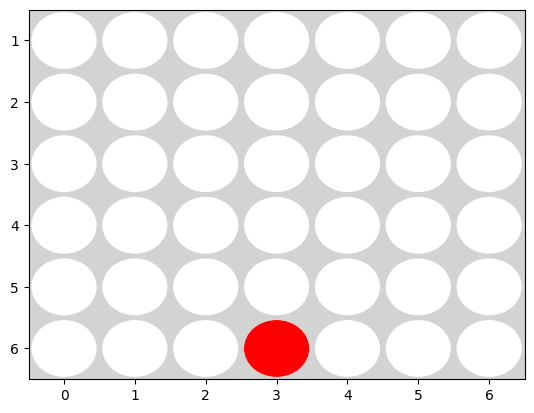

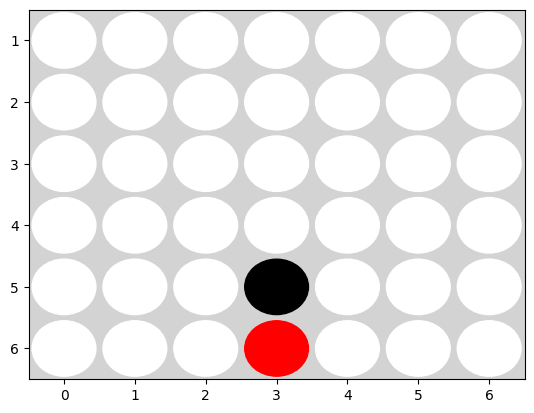

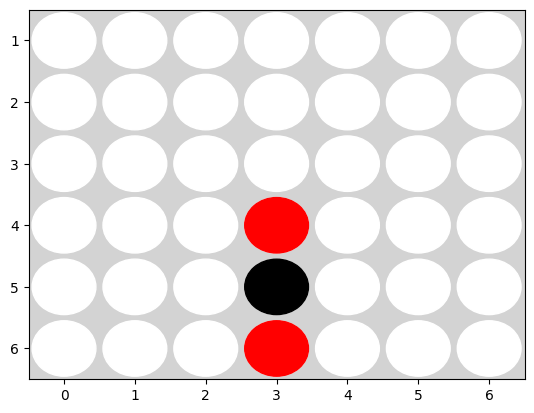

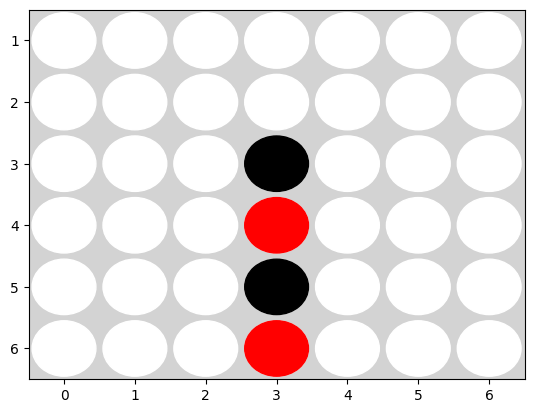

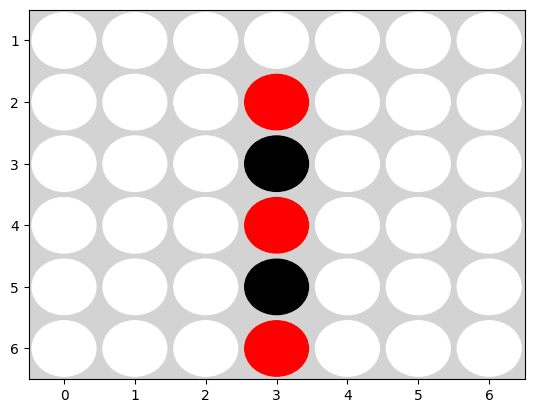

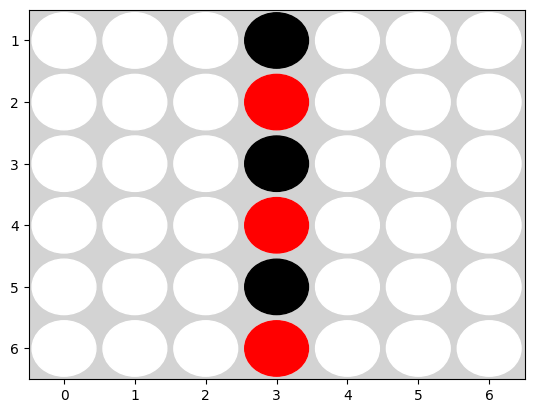

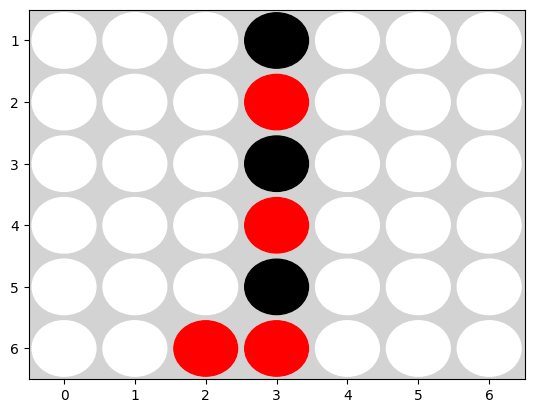

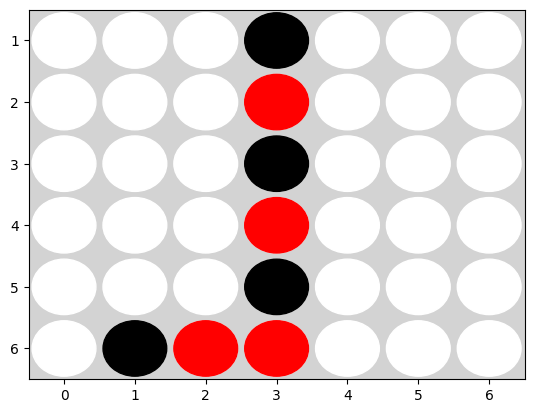

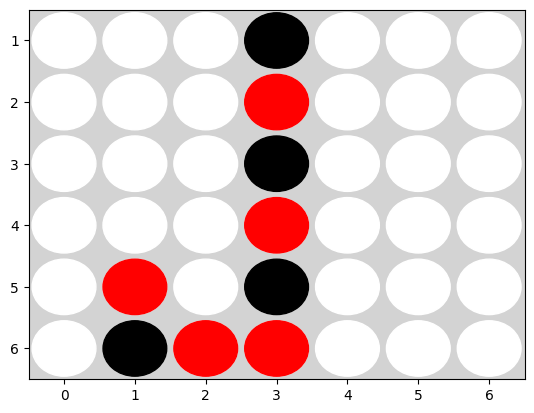

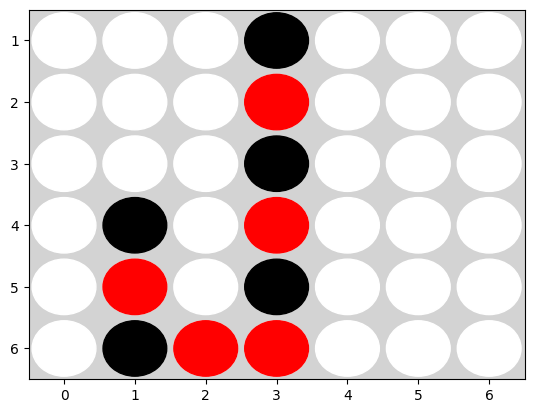

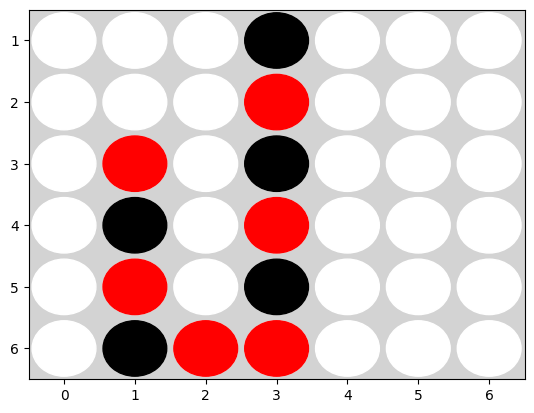

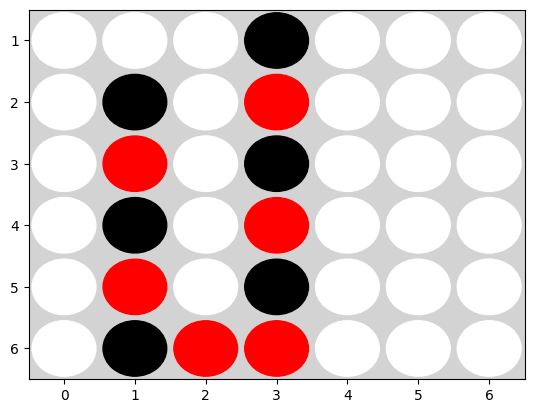

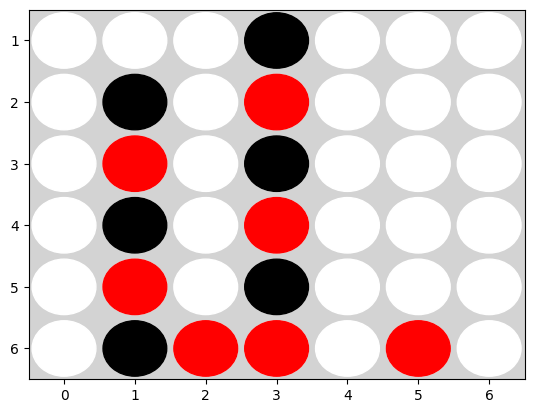

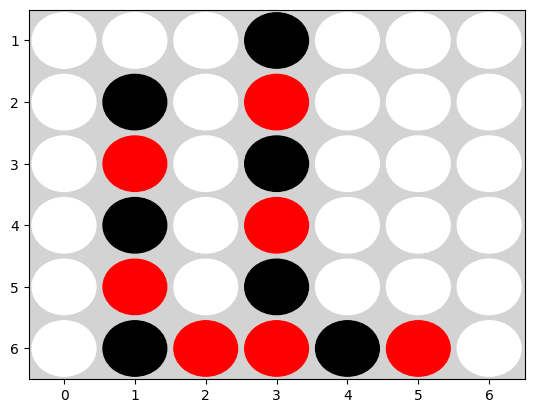

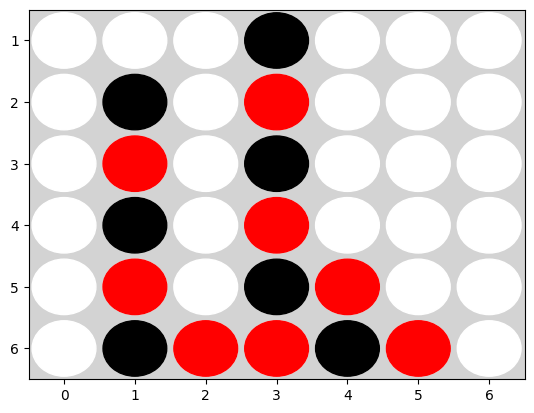

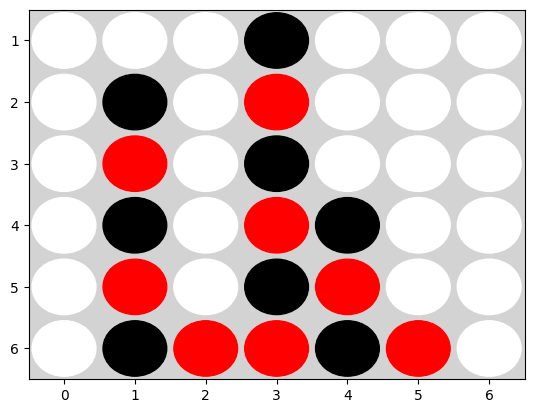

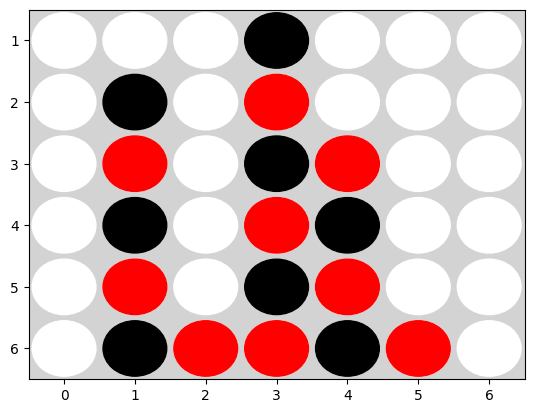

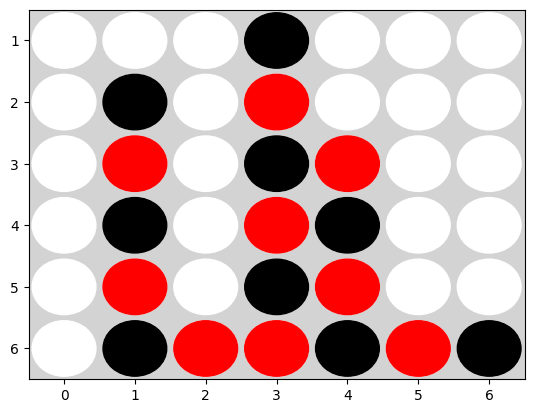

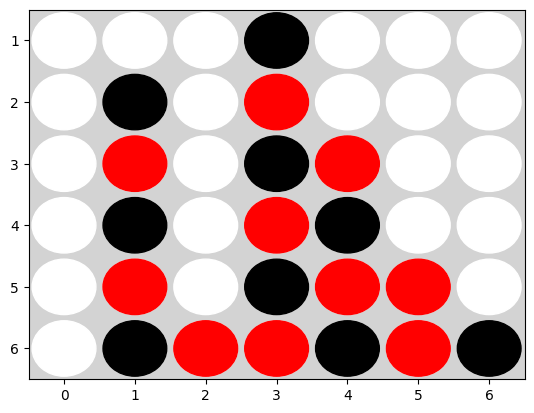

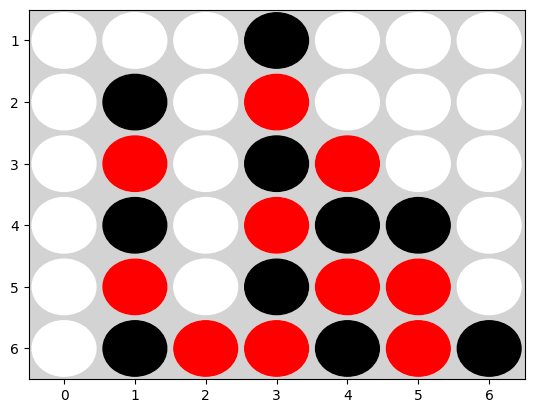

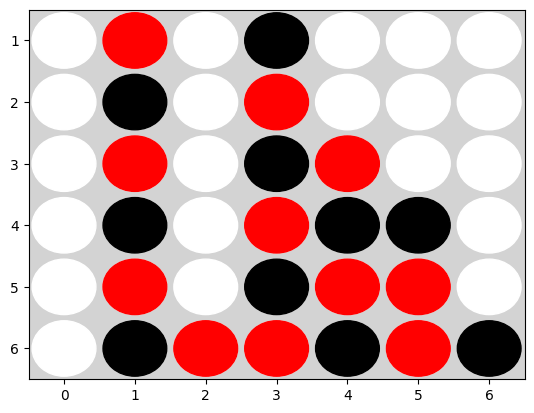

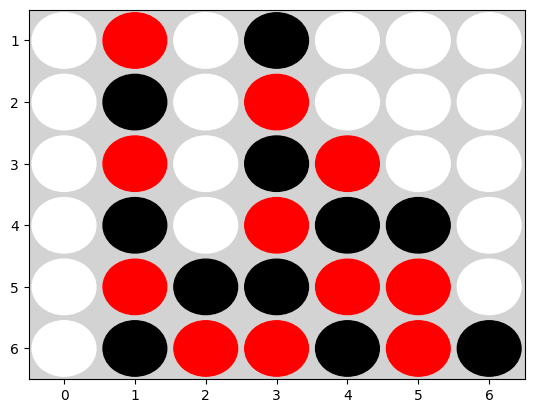

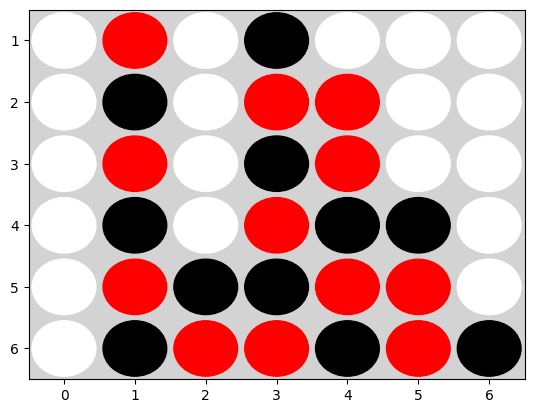

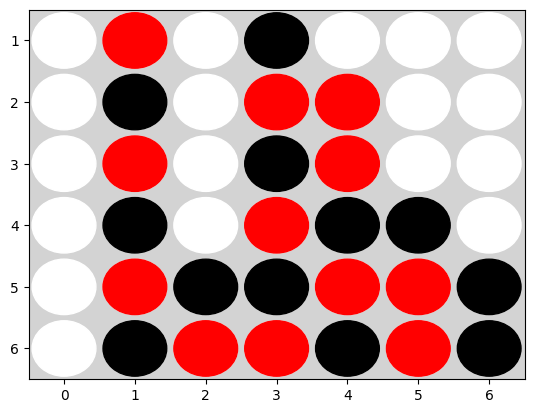

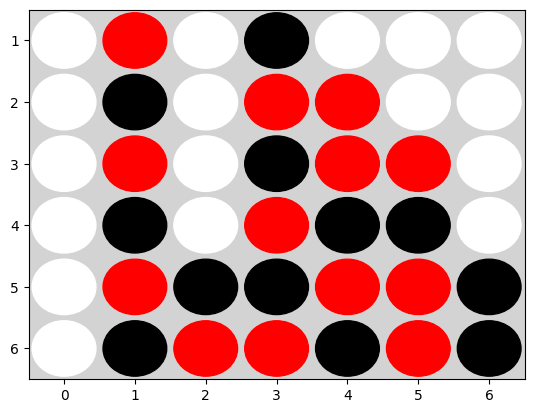

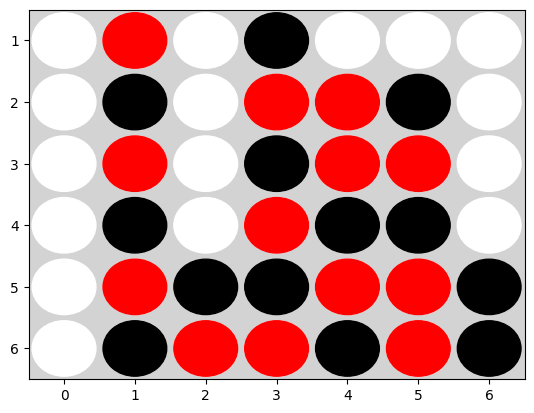

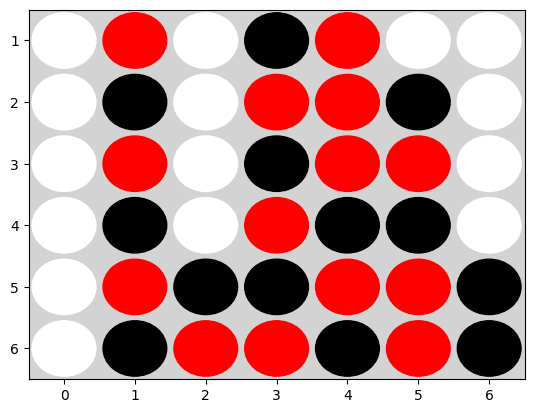

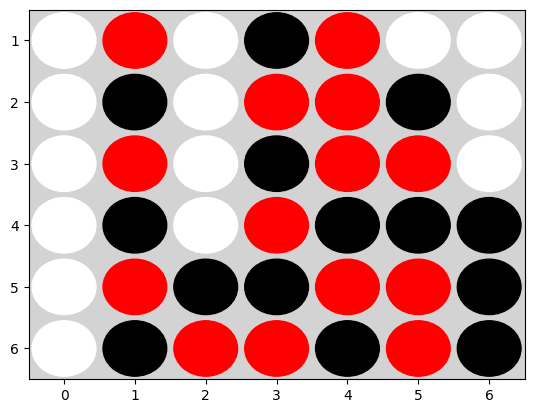

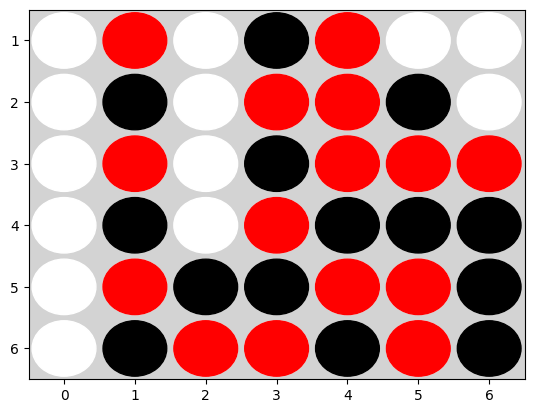

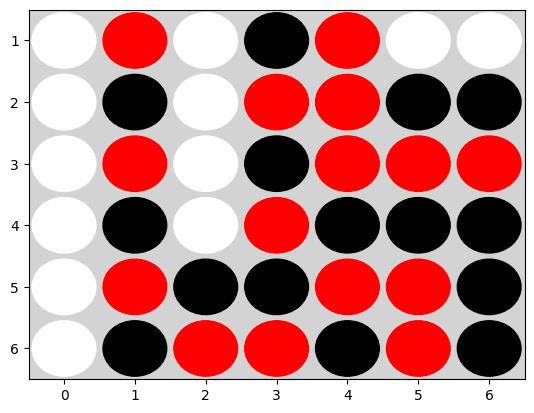

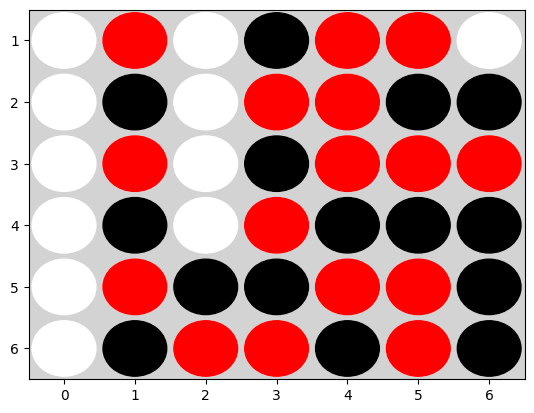

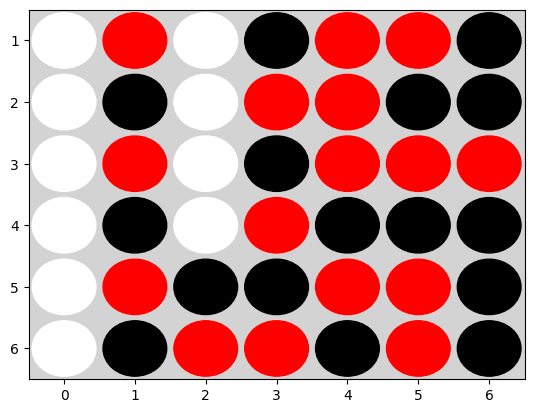

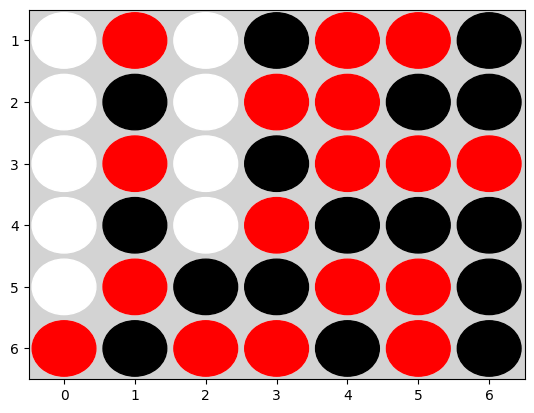

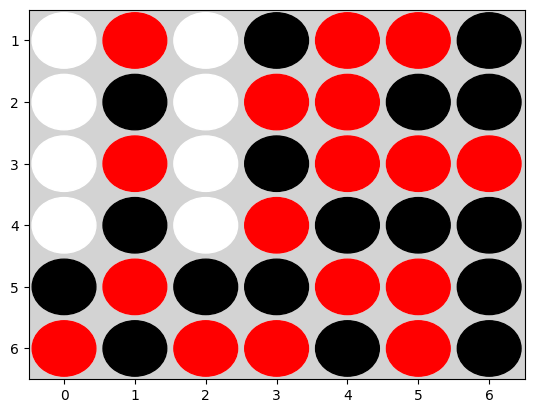

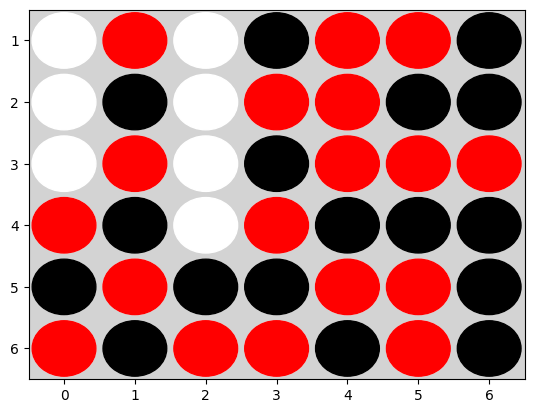

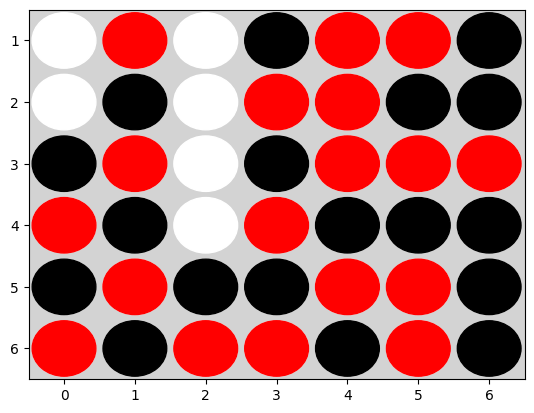

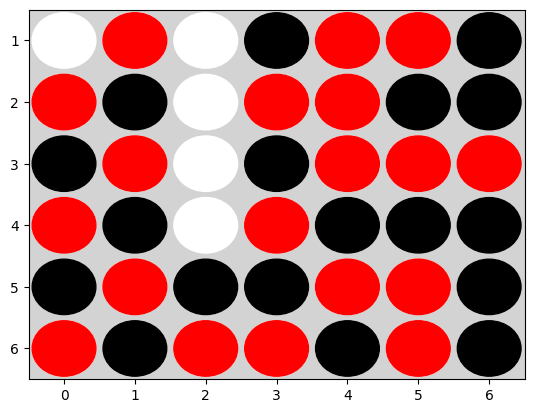

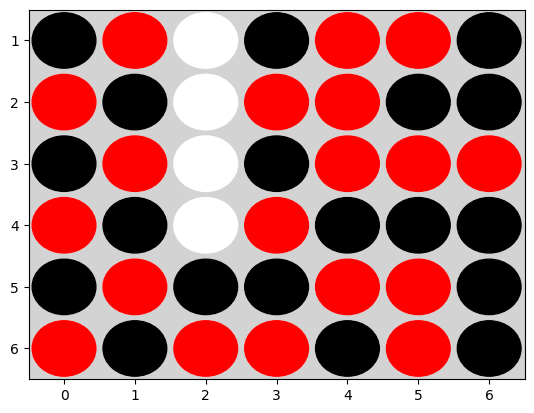

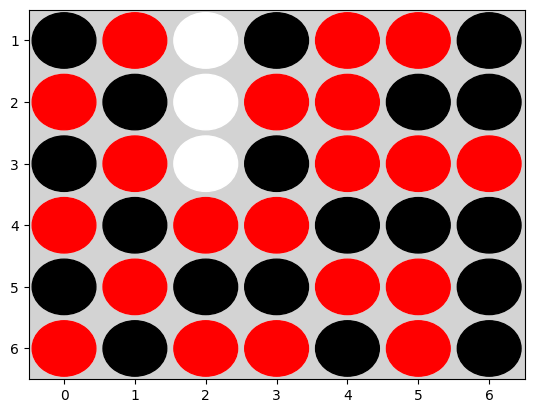

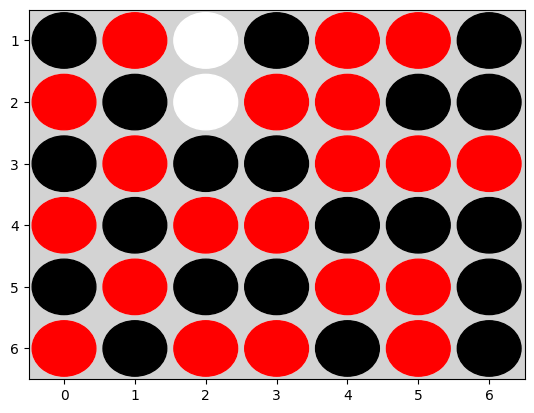

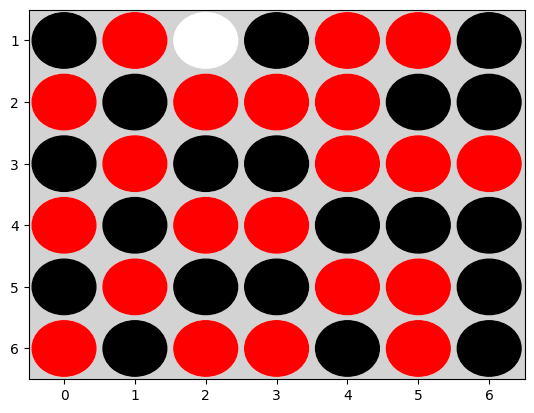

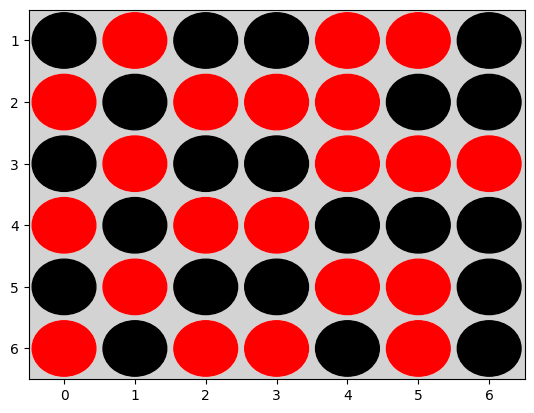

player 0 wins: 0
player 1 wins: 0
ties: 1
score: 0.0


In [20]:
agents = [
    UCBRolloutExpertAgent(100, model=model, params=params68, batch_size=14),
    UCBRolloutExpertAgent(100, model=model, params=params72, batch_size=14)
]

pl = get_piece_locations()

key = jax.random.PRNGKey(int(time.time()))
sim = Simulator(init_game(1), agents)
while(any_active_games(sim.game_state)):
  #print(jax.nn.softmax(model.apply(params, state_to_array(sim.game_state, pl)))[0])
  sim.step()
  draw_game(sim.game_state)
  

results = get_winners(sim.game_state)
print(f'player 0 wins: {jnp.count_nonzero(results == -1)}')
print(f'player 1 wins: {jnp.count_nonzero(results == 1)}')
print(f'ties: {jnp.count_nonzero(results == 0)}')
print(f'score: {jnp.mean(results)}')

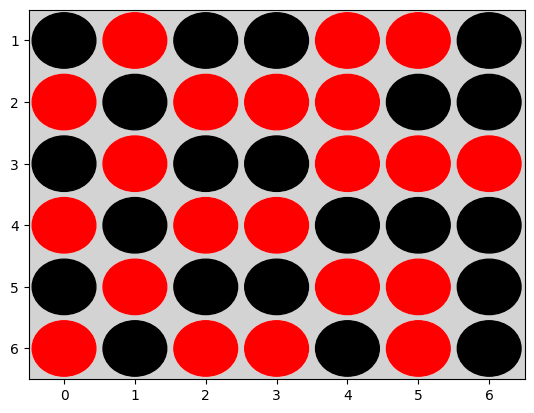

In [21]:
draw_game(sim.game_state, 1)

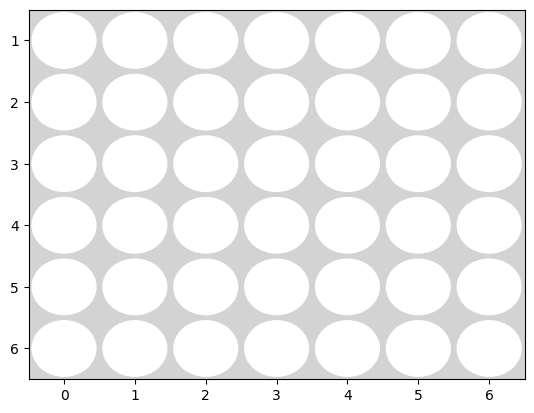

NameError: name 'params' is not defined

In [24]:

UCB_agent = UCBRolloutExpertAgent(100, model=model, params=params68, batch_size=14)
RO_agent = RolloutAgent(batch_size=100)

game_state = init_game(1)

draw_game(game_state)

pl = get_piece_locations()

key = jax.random.PRNGKey(int(time.time()))
print(jax.nn.softmax(model.apply(params, state_to_array(game_state, pl))))
UCB_agent.choose(game_state)